In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import time, os
import random
import seaborn as sns

import astropy
from astropy.io import fits

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, LeakyReLU
from tensorflow.keras.utils import to_categorical
from tensorboard.plugins.hparams import api as hp

from tensorflow.keras import activations
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import Model

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from scipy.stats import bernoulli

from matplotlib.ticker import FormatStrFormatter

2022-12-09 19:41:05.617037: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-09 19:41:05.731084: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-09 19:41:05.731102: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-09 19:41:06.469922: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

In [2]:
np.random.seed(0)
scaler = StandardScaler()

### Conjunto de datos: 

In [3]:
with fits.open('https://github.com/igomezv/cosmo_tools/blob/main/COB_22/Viviana_Acquaviva/DEEP2_uniq_Terapix_Subaru_v1.fits?raw=true') as data:
    df = pd.DataFrame(np.array(data[1].data).byteswap().newbyteorder()) #see https://numpy.org/devdocs/user/basics.byteswapping.html#changing-byte-ordering

In [4]:
df.head()

,objno_deep2,ra_deep2,dec_deep2,magb,magr,magi,pgal,sfd_ebv,class,subclass,...,ra_subaru,dec_subaru,y,yerr,y_apercor,yerr_aper,yerr_apercor,y(sexflag),y_radius_arcsec,subaru_source
0,11001673,213.868704,51.956445,23.487745,23.143082,22.582092,1.000000,0.010943,b'',b'',...,213.868626,51.956443,21.869627,0.060918,21.926356,0.041955,0.141778,3.0,0.656514,1
1,11001699,213.810471,51.942316,22.067692,20.034674,19.545080,3.000000,0.011014,b'GALAXY',b'',...,213.810455,51.942321,18.757229,0.005813,18.811085,0.004386,0.050987,3.0,0.744269,1
2,11001770,213.848431,51.948876,24.144438,24.103180,24.020006,3.000000,0.010856,b'GALAXY',b'',...,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.0,-99.000000,-99
3,11001800,213.831758,51.952548,25.336836,23.508480,23.081087,0.509809,0.010823,b'GALAXY',b'',...,213.831766,51.952544,22.404269,0.088970,22.535600,0.053497,0.094733,0.0,0.455820,1
4,11001860,213.832550,51.954174,24.382738,23.401484,22.572845,3.000000,0.010827,b'GALAXY',b'',...,213.832574,51.954175,22.242717,0.070760,22.100980,0.033256,0.073067,0.0,0.442022,1


In [5]:
features = df[['u_apercor', 'g_apercor', 'r_apercor', 'i_apercor', 'z_apercor','y_apercor']]
features.head()

,u_apercor,g_apercor,r_apercor,i_apercor,z_apercor,y_apercor
0,23.543491,23.430495,23.100311,22.768970,22.223810,21.926356
1,30.848978,28.989668,19.027422,99.000000,99.000000,18.811085
2,24.324670,24.273606,24.150319,23.446252,23.574236,-99.000000
3,99.000000,24.804309,23.636544,23.009222,22.689591,22.535600
4,24.362068,24.136913,23.490342,22.777181,22.319676,22.100980


In [6]:
target = df['zhelio']
target.head()

0    1.115261
1    0.290608
2    0.605744
3    1.306796
4    0.957669
Name: zhelio, dtype: float32

In [7]:
mags = df[['u_apercor', 'g_apercor', 'r_apercor', 'i_apercor', 'z_apercor','y_apercor','zquality','cfhtls_source']]

In [8]:
mags = mags[mags['zquality'] >= 3]

mags.shape

(16857, 8)

In [9]:
mags.shape

(16857, 8)

In [10]:
mags = mags[mags > -10].dropna()
mags = mags[mags < 90].dropna()

In [11]:
mags = mags[mags['cfhtls_source'] == 0]

In [12]:
mags.shape

(6307, 8)

In [13]:
params = ['u_apercor', 'g_apercor', 'r_apercor', 'i_apercor', 'z_apercor','y_apercor']
features_ext = mags.copy()
for i, name1 in enumerate(params):
    for j, name2 in enumerate(params):
        if i >=j: continue #build only one pair, avoid zero colors
        features_ext[name1 + '-' + name2] = features[name1] - features[name2]

In [14]:
features_ext.head()

,u_apercor,g_apercor,r_apercor,i_apercor,z_apercor,y_apercor,zquality,cfhtls_source,u_apercor-g_apercor,u_apercor-r_apercor,...,g_apercor-r_apercor,g_apercor-i_apercor,g_apercor-z_apercor,g_apercor-y_apercor,r_apercor-i_apercor,r_apercor-z_apercor,r_apercor-y_apercor,i_apercor-z_apercor,i_apercor-y_apercor,z_apercor-y_apercor
1251,24.244393,23.979583,23.522136,22.911041,22.525773,22.329098,4,0.0,0.264811,0.722258,...,0.457447,1.068542,1.453810,1.650485,0.611094,0.996362,1.193037,0.385268,0.581943,0.196675
1253,24.489104,23.916151,22.923651,21.873752,21.306495,21.251440,4,0.0,0.572953,1.565453,...,0.992500,2.042399,2.609656,2.664711,1.049899,1.617157,1.672212,0.567258,0.622312,0.055055
1261,24.873959,22.973893,21.465850,20.788420,20.462283,20.413696,3,0.0,1.900066,3.408108,...,1.508042,2.185473,2.511610,2.560196,0.677430,1.003568,1.052154,0.326138,0.374724,0.048586
1271,24.529042,24.338631,23.891189,23.206102,22.989344,23.112382,4,0.0,0.190411,0.637853,...,0.447442,1.132529,1.349287,1.226250,0.685087,0.901845,0.778808,0.216758,0.093721,-0.123037
1272,23.641180,23.387447,22.975301,22.235199,21.809658,21.559483,4,0.0,0.253733,0.665879,...,0.412146,1.152248,1.577789,1.827964,0.740102,1.165643,1.415818,0.425541,0.675717,0.250175


In [15]:
target = target[features_ext.index]

In [16]:
features_paper = features_ext[['u_apercor-g_apercor','g_apercor-r_apercor', \
            'r_apercor-i_apercor','i_apercor-z_apercor','z_apercor-y_apercor','i_apercor']]

In [17]:
# Produces test split.
X_train, X_val, Y_train, Y_val = train_test_split(features_paper, target, test_size=0.2)

In [18]:
# loss -> val_loss
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.0,
                                   patience=200,
                                   restore_best_weights=True, verbose=False)
                                   ]

n_cols = 1
epochs=200

In [19]:
def train_test_model(hparams):    
    
    # Train LSTM model and predict on validation set
    model = tf.keras.Sequential()
    model.add(Dense(int(X_train.shape[1])))
    
    for i in range(hparams['HP_LAYERS']):        
        model.add(Dense(hparams['HP_NUM_UNITS'], activation='relu'))
    model.add(Dense(1, activation='linear'))
     
    optimizer = tf.keras.optimizers.Adam(learning_rate=hparams['HP_LEARNING'], beta_1=0.9, beta_2=0.999, epsilon=1e-3)
    model.compile(
            optimizer=optimizer,
            loss='mse', 
            metrics=['mean_squared_error'])
    
    # Run with 1 epoch to speed things up for demo purposes

    train = model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_val, Y_val),
              callbacks=callbacks, batch_size=hparams['HP_BATCHSIZE'], shuffle=False, verbose=False)

    _, loss = model.evaluate(X_val, Y_val)
    
    return model, loss, train.history

### Arquitectura del modelo proveniente de la malla de hiperparámetros

In [20]:
hparams = {'HP_LAYERS': 4, 'HP_NUM_UNITS': 200, 'HP_BATCHSIZE': 64, 'HP_LEARNING':0.001}

In [21]:
model1, loss_test1, history1 = train_test_model(hparams)

2022-12-09 19:41:07.675982: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 19:41:07.676175: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-09 19:41:07.676230: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-12-09 19:41:07.676276: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-12-09 19:41:07.676321: W tensorflow/c

40/40 [==============================] - 0s 907us/step - loss: 0.0333 - mean_squared_error: 0.0333


Text(0.5, 1.0, 'Grid')

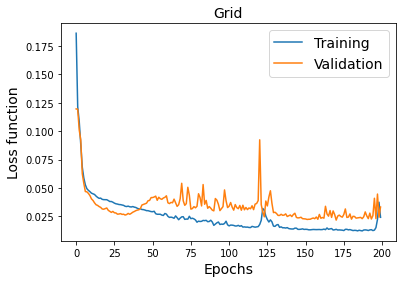

In [22]:
plt.plot(history1['loss'], label='Training')
plt.plot(history1['val_loss'], label='Validation')
plt.ylabel('Loss function', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
# plt.ylim(-5, 210)
plt.legend(loc='upper right', fontsize=14)
plt.title("Grid", fontsize=14)
# plt.savefig("loss_jla_grid.png")

In [23]:
print("number of epochs", len(history1['loss']))

number of epochs 200


In [24]:
model1.save("models/model_grid_zphoto.h5")

In [25]:
loss_test1

0.03328835591673851

In [26]:
zpred_grid = model1.predict(X_val)

40/40 [==============================] - 0s 703us/step


Text(0, 0.5, 'ANN prediction for redshift')

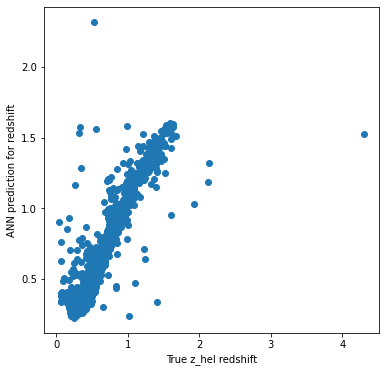

In [27]:
plt.figure(figsize=(6,6))
plt.scatter(Y_val, zpred_grid)
plt.xlabel("True z_hel redshift")
plt.ylabel("ANN prediction for redshift")


### Arquitectura del modelo proveniente del algoritmo genético 1

In [28]:
hparams_gen = {'HP_LAYERS':4, 'HP_NUM_UNITS': 200, 'HP_BATCHSIZE': 16, 'HP_LEARNING':0.001}

In [29]:
model2, loss_test2, history2 = train_test_model(hparams_gen)

40/40 [==============================] - 0s 929us/step - loss: 0.0154 - mean_squared_error: 0.0154


Text(0.5, 1.0, 'Genetic algorithm')

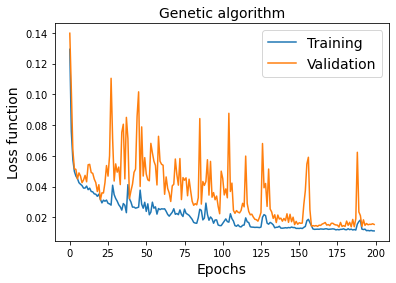

In [30]:
plt.plot(history2['loss'], label='Training')
plt.plot(history2['val_loss'], label='Validation')
plt.ylabel('Loss function', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
# plt.ylim(-5, 210)
plt.legend(loc='upper right', fontsize=14)
plt.title("Genetic algorithm", fontsize=14)
# plt.savefig("loss_jla_grid.png")

In [31]:
loss_test2

0.015406942926347256

In [32]:
model2.save("models/model_genetic_zphoto.h5")

In [33]:
zpred_genetic = model2.predict(X_val)

40/40 [==============================] - 0s 817us/step


### Arquitectura del modelo proveniente del algoritmo genético 2
4 	100 	0.0010 	16

In [42]:
hparams_gen2 = {'HP_LAYERS': 4, 'HP_NUM_UNITS': 100, 'HP_BATCHSIZE': 16, 'HP_LEARNING':0.001}

In [43]:
model3, loss_test3, history3 = train_test_model(hparams_gen2)

40/40 [==============================] - 0s 769us/step - loss: 0.0232 - mean_squared_error: 0.0232


Text(0.5, 1.0, 'Genetic algorithm')

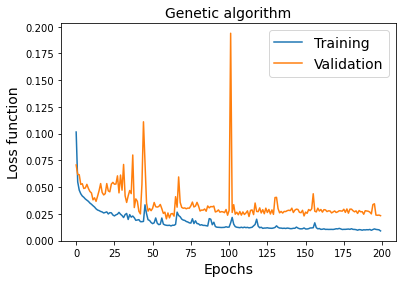

In [44]:
plt.plot(history3['loss'], label='Training')
plt.plot(history3['val_loss'], label='Validation')
plt.ylabel('Loss function', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
# plt.ylim(-5, 210)
plt.legend(loc='upper right', fontsize=14)
plt.title("Genetic algorithm", fontsize=14)
# plt.savefig("loss_jla_grid.png")

In [45]:
loss_test3

0.023228826001286507

In [46]:
model3.save("models/model_genetic_zphoto2.h5")

In [47]:
zpred_genetic2 = model3.predict(X_val)

40/40 [==============================] - 0s 659us/step


Text(0.5, 1.0, 'Genetic algorithm')

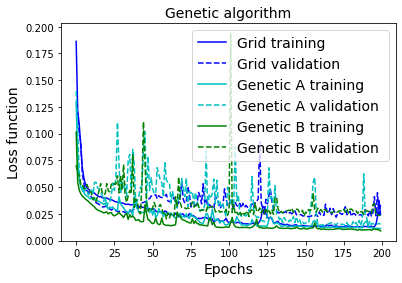

In [49]:
plt.plot(history1['loss'], label='Grid training', color = 'blue')
plt.plot(history1['val_loss'], label='Grid validation', linestyle='--', color = 'blue')
plt.plot(history2['loss'], label='Genetic A training ', color = 'c')
plt.plot(history2['val_loss'], label='Genetic A validation ', linestyle='--', color = 'c')
plt.plot(history3['loss'], label='Genetic B training ', color = 'g')
plt.plot(history3['val_loss'], label='Genetic B validation ', linestyle='--', color = 'g')
plt.ylabel('Loss function', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
# plt.ylim(-5, 210)
plt.legend(loc='upper right', fontsize=14)
plt.title("Genetic algorithm", fontsize=14)
# plt.savefig("loss_jla_grid.png")

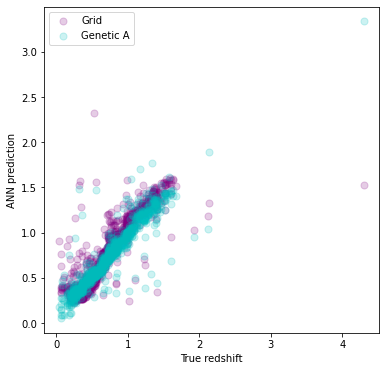

In [50]:
plt.figure(figsize=(6,6))
plt.scatter(Y_val, zpred_grid, label='Grid', color='purple', alpha=0.2, marker = 'o', s=50)
plt.scatter(Y_val, zpred_genetic, label='Genetic A', color='c', alpha=0.2, marker = 'o', s=50)
# plt.scatter(Y_val, zpred_genetic2, label='Genetic B', color='g', alpha=0.2, marker = 'o', s=50)
plt.xlabel("True redshift")
plt.ylabel("ANN prediction")
plt.legend()